In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("/Users/gulenaydefneozen/Downloads/tumor.csv")

In [3]:
df

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
678,776715,3,1,1,1,3,2,1,1,1,2
679,841769,2,1,1,1,2,1,1,1,1,2
680,888820,5,10,10,3,7,3,8,10,2,4
681,897471,4,8,6,4,3,4,10,6,1,4


In [4]:
# Tumor Classification: Biostatistics Project
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from scipy.stats import ttest_ind
import os
df.drop(columns=['Sample code number'], inplace=True)

# Binary target: 2 = benign, 4 = malignant
df['Class'] = df['Class'].map({2: 0, 4: 1})



Class Distribution:
 Class
0    444
1    239
Name: count, dtype: int64


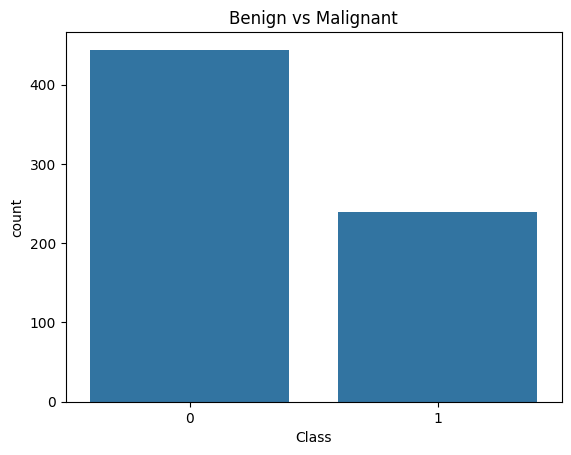

In [5]:
# EDA
print("Class Distribution:\n", df['Class'].value_counts())
sns.countplot(x='Class', data=df)
plt.title('Benign vs Malignant')
plt.show()


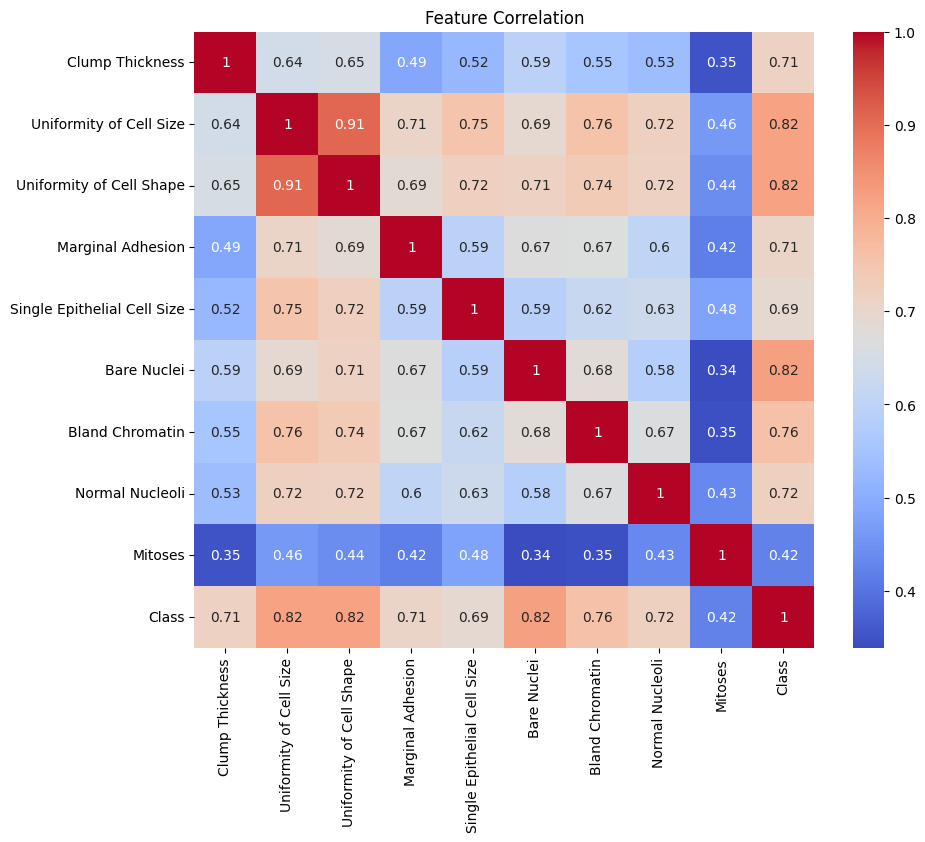

In [6]:
# Correlation Matrix
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

In [7]:
# Group Stats
group_stats = df.groupby('Class').mean()
print("\nGroup Means by Class:\n", group_stats)



Group Means by Class:
        Clump Thickness  Uniformity of Cell Size  Uniformity of Cell Shape  \
Class                                                                       
0             2.963964                 1.306306                  1.414414   
1             7.188285                 6.577406                  6.560669   

       Marginal Adhesion  Single Epithelial Cell Size  Bare Nuclei  \
Class                                                                
0               1.346847                     2.108108     1.346847   
1               5.585774                     5.326360     7.627615   

       Bland Chromatin  Normal Nucleoli   Mitoses  
Class                                              
0             2.083333         1.261261  1.065315  
1             5.974895         5.857741  2.602510  


In [8]:
# T-tests
print("\nT-tests for each feature:")
for col in df.columns[:-1]:
    stat, p = ttest_ind(df[df['Class']==0][col], df[df['Class']==1][col])
    print(f"{col}: p-value = {p:.4f}")


T-tests for each feature:
Clump Thickness: p-value = 0.0000
Uniformity of Cell Size: p-value = 0.0000
Uniformity of Cell Shape: p-value = 0.0000
Marginal Adhesion: p-value = 0.0000
Single Epithelial Cell Size: p-value = 0.0000
Bare Nuclei: p-value = 0.0000
Bland Chromatin: p-value = 0.0000
Normal Nucleoli: p-value = 0.0000
Mitoses: p-value = 0.0000


In [9]:
# Train/Test Split
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


In [11]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [12]:
# Evaluation Function
def evaluate(model_name, y_true, y_pred):
    print(f"\n{model_name} Evaluation")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

evaluate("Logistic Regression", y_test, y_pred_lr)
evaluate("Random Forest", y_test, y_pred_rf)


Logistic Regression Evaluation
[[78  1]
 [ 5 53]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        79
           1       0.98      0.91      0.95        58

    accuracy                           0.96       137
   macro avg       0.96      0.95      0.95       137
weighted avg       0.96      0.96      0.96       137


Random Forest Evaluation
[[78  1]
 [ 6 52]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        79
           1       0.98      0.90      0.94        58

    accuracy                           0.95       137
   macro avg       0.95      0.94      0.95       137
weighted avg       0.95      0.95      0.95       137



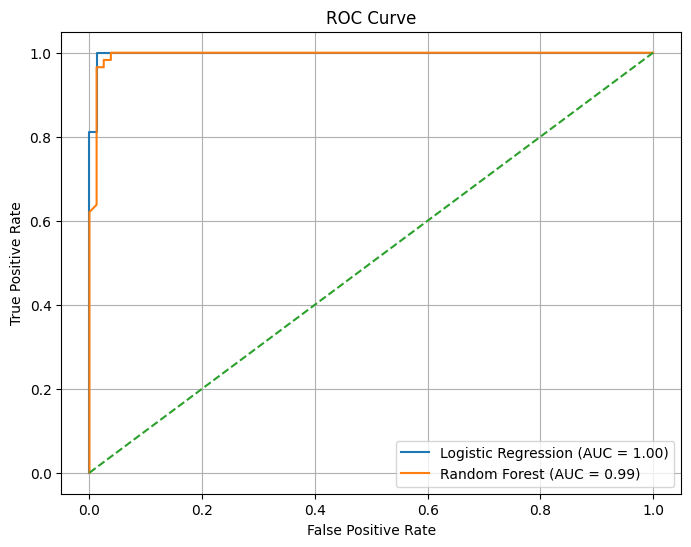

In [13]:
# ROC Curves
plt.figure(figsize=(8,6))
for model, y_pred_proba, label in [
    (lr, lr.predict_proba(X_test)[:,1], 'Logistic Regression'),
    (rf, rf.predict_proba(X_test)[:,1], 'Random Forest')]:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc:.2f})")

plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


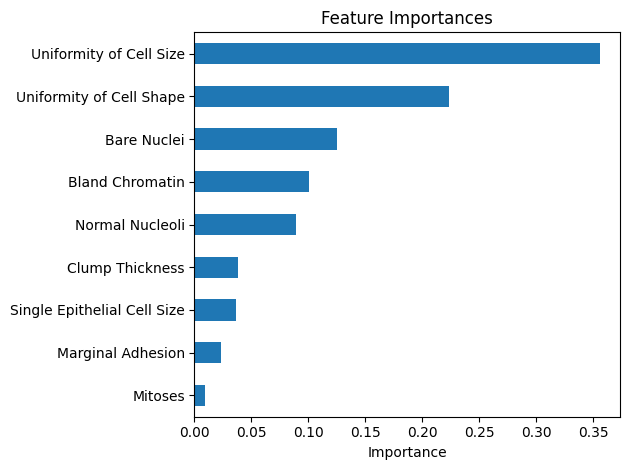

In [14]:
# Feature Importance (Random Forest)
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp.sort_values().plot(kind='barh', title='Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()